In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d ahmedmoorsy/facial-expression

Dataset URL: https://www.kaggle.com/datasets/ahmedmoorsy/facial-expression
License(s): DbCL-1.0
 97% 188M/193M [00:05<00:00, 66.7MB/s]
100% 193M/193M [00:05<00:00, 36.9MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/facial-expression.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# *Importing libraries*

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

In [5]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))

In [6]:
filname = '/content/fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names = ['emotion', 'pixels', 'usage']
df = pd.read_csv(filname, names=names, na_filter=False)
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


# * Preprocessing*

In [7]:
def getData(filname):
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [8]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [9]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

# *Train and Test Split*

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

# *Data Augmentation*

In [11]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# *Model*

In [12]:
def my_model():
    model = Sequential()
    input_shape = (48, 48, 1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-3))
    return model
model = my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       4

In [34]:
K.clear_session()
model = my_model()
path_model = 'model_filter.h5'

# *Training the model*

In [35]:
h = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    epochs=50,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[ModelCheckpoint(filepath=path_model, save_best_only=True, save_weights_only=False)]
)

Epoch 1/50
504/504 [==============================] - 85s 56ms/step - loss: 1.8953 - accuracy: 0.2591 - val_loss: 1.6926 - val_accuracy: 0.3366
Epoch 2/50
  1/504 [..............................] - ETA: 33s - loss: 1.4705 - accuracy: 0.4531

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


504/504 [==============================] - 22s 43ms/step - loss: 1.5707 - accuracy: 0.3884 - val_loss: 1.7959 - val_accuracy: 0.2711
Epoch 3/50
504/504 [==============================] - 24s 47ms/step - loss: 1.3844 - accuracy: 0.4699 - val_loss: 1.4124 - val_accuracy: 0.4505
Epoch 4/50
504/504 [==============================] - 22s 44ms/step - loss: 1.2717 - accuracy: 0.5178 - val_loss: 1.2577 - val_accuracy: 0.5199
Epoch 5/50
504/504 [==============================] - 22s 44ms/step - loss: 1.2021 - accuracy: 0.5463 - val_loss: 1.1555 - val_accuracy: 0.5623
Epoch 6/50
504/504 [==============================] - 22s 44ms/step - loss: 1.1584 - accuracy: 0.5625 - val_loss: 1.2315 - val_accuracy: 0.5383
Epoch 7/50
504/504 [==============================] - 24s 48ms/step - loss: 1.1218 - accuracy: 0.5797 - val_loss: 1.1027 - val_accuracy: 0.5818
Epoch 8/50
504/504 [==============================] - 25s 49ms/step - loss: 1.0920 - accuracy: 0.5915 - val_loss: 1.1534 - val_accuracy: 0.5637
Epo

In [36]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    plt.show()

# *Predicting Result*

In [37]:
from skimage import io
img = image.load_img('/content/happy.jpg', color_mode = "grayscale", target_size=(48, 48))
show_img = image.load_img('/content/happy.jpg',color_mode = "rgb", target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255

1/1 [==============================] - 0s 122ms/step
[2.8283754e-04 6.4745956e-07 2.4954008e-02 3.2393205e-01 3.1363234e-01
 8.0232625e-04 3.3639580e-01]


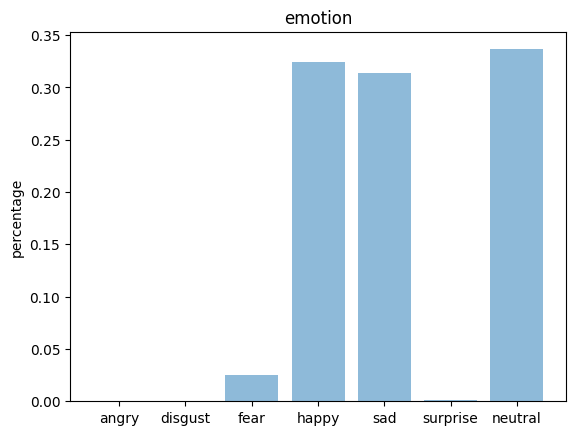

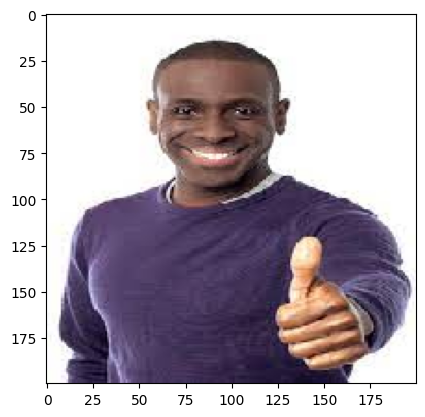

Expression Prediction: neutral


In [38]:
custom = model.predict(x)
print(custom[0])
emotion_analysis(custom[0])
x = np.array(x, 'float32')
x = x.reshape([48, 48])
plt.gray()
plt.imshow(show_img)
plt.show()
m = 0.000000000000000000001
a = custom[0]
for i in range(len(a)):
    if a[i] > m:
        m = a[i]
        ind = i


print('Expression Prediction:', objects[ind])

1/1 [==============================] - 0s 23ms/step
[3.6872387e-02 6.7483675e-06 3.9075488e-01 7.8607723e-03 4.5779625e-01
 6.6553014e-03 1.0005365e-01]


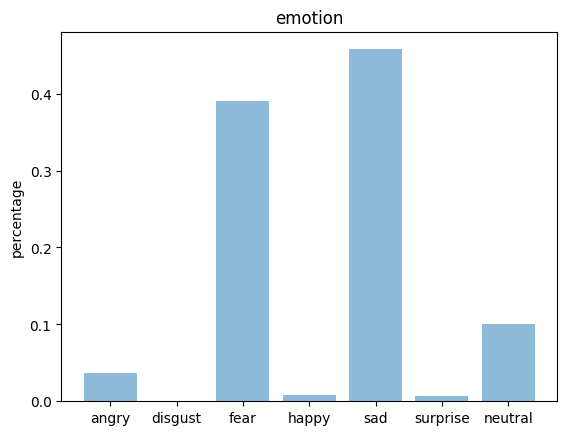

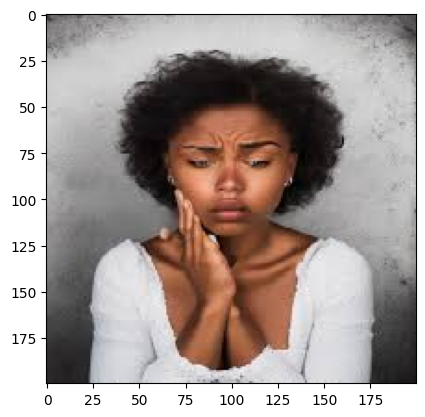

Expression Prediction: sad


In [39]:
img = image.load_img('/content/sad.jpg', grayscale=True, target_size=(48, 48))
show_img = image.load_img('/content/sad.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255
custom = model.predict(x)
print(custom[0])
emotion_analysis(custom[0])
x = np.array(x, 'float32')
x = x.reshape([48, 48])
plt.gray()
plt.imshow(show_img)
plt.show()
m = 0.000000000000000000001
a = custom[0]
for i in range(len(a)):
    if a[i] > m:
        m = a[i]
        ind = i


print('Expression Prediction:', objects[ind])

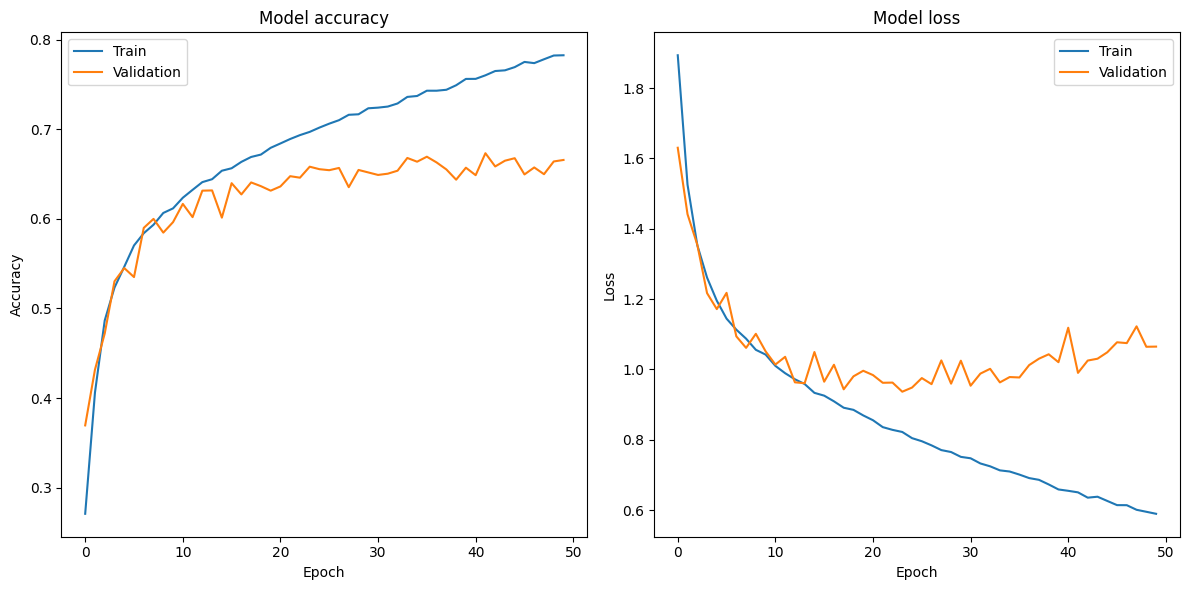

In [31]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()
